<a href="https://colab.research.google.com/github/pglorio/Edge-of-Stability/blob/main/EoS_DeepLinear_polished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q pyhessian functorch

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F 
import random
import math
import copy
import time
import pickle
from IPython.display import clear_output

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from pyhessian import hessian

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler


USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

from google.colab import drive
drive.mount('/content/gdrive')


using device: cpu
Mounted at /content/gdrive


In [ ]:
### Define training ###

def trainer(model, optimizer, epochs, loader_train, plot_timesteps):
    # Make data dic, contains training data
    data = {'loss' :[], 'test_loss': [], 'ws':[], 'test_acc':[], 'train_acc': [], 'gradfc1':[], 'gradfc2':[], 'fc1.ws':[], 'fc2.ws':[],
            'train_topeigs': [], 'test_topeigs': [], 'train_trace': [], 'test_trace': []}
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    criterion1 = nn.MSELoss()
    #criterion2 = nn.CrossEntropyLoss()
    stopwatch = 0
    for e in range(epochs):

        for t, (x, y) in enumerate(loader_train):
            
            model.train()  # put model to training mode
            scores = model(x)
            loss = criterion1(scores, y)
            #loss = criterion2(scores.squeeze(), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

            if e % plot_timesteps == 0 and t ==0:
              data['gradfc1'].append((model.fc1.weight.grad**2).mean().detach().clone().cpu())
              data['gradfc2'].append((model.fc2.weight.grad**2).mean().detach().clone().cpu())
              
              # Use Pyhessian package
              hessian_comp = hessian(model, criterion1, data=(x, y), cuda=(device.type=='cuda'))
              top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)
              trace = np.mean(hessian_comp.trace())
              
              ##t_loss, t_eigs, t_trace = test_loss(model, loader_test)
              #t_loss = test_loss(model, loader_test)
              #data['test_loss'].append(t_loss.detach().clone().cpu())
              ##data['test_topeigs'].append(np.array(t_eigs))
              ##data['test_trace'].append(t_trace)              
              with torch.no_grad():
                #data['test_acc'].append((check_accuracy(loader_test, model)[2]*100))
                #data['train_acc'].append((check_accuracy(loader_train, model)[2]*100))
                #this below remove for test
                #data['test_loss'].append(test_loss(model, loader_test).detach().clone().cpu())
                data['loss'].append(loss.detach().clone().cpu())
                data['fc1.ws'].append((model.fc1.weight**2).mean().detach().clone().cpu())
                data['fc2.ws'].append((model.fc2.weight**2).mean().detach().clone().cpu())
                data['train_topeigs'].append(np.array(top_eigenvalues))
                data['train_trace'].append(trace) 
            
            if e % 100 == 0 and t==0:
              with torch.no_grad():
                end1 = time.time()
                clear_output()
                print(f'Epoch {(e+1)} / {epochs}, Top eig = {top_eigenvalues}, Time: {end1-start} s')#.item()
                
                #print(f'Test acc: {check_accuracy(loader_test, model)[2]*100}% correctly')
                #print(f'Train acc: {check_accuracy(loader_train, model)[2]*100}% correctly')
                
                #print("Time:", (end1-start), "s")

              
    return data

In [ ]:
### Deep Linear model architecture ###

def flatten(x):
  N = x.shape[0] # read in N, C, H, W
  return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class fcc(nn.Module):
  def __init__(self, in_size, h_size, out_size):
    super(fcc, self).__init__()

    self.in_size = in_size
    self.h_size = h_size
    self.out_size = out_size

    layers = [nn.Linear(h_size, h_size, bias=False) for _ in range(depth-1)] + [nn.Linear(h_size, out_size, bias=False)]
    layer_dict = {f"fc{i+1}" : layer for i, layer in enumerate(layers)}
    for name, layer in layer_dict.items():
      setattr(self, name, layer)

    for i in range(depth):
      fc = getattr(self, f"fc{i+1}") # Get the attribute by name
      torch.nn.init.xavier_uniform_(fc.weight) # Initialize the weight

  def forward(self, x):
     x = flatten(x)
     for i in range(depth):
         fc = getattr(self, f"fc{i+1}")
         x = fc(x)
     return x

In [ ]:
lr = 2/50      # learning rate
epochs = 1000
plot_timesteps = 30    # record things every plot_timesteps

dataset_size=50
d_in=50         # input dimension
d_out=50        # output dimension
d_hidden=50     # hidden layers dimension
depth=21        # model depth

torch.manual_seed(0)
np.random.seed(1)
random.seed(2)


### Training set ###

X= np.random.normal(loc=0,scale=1.0,size=(dataset_size, d_in))
Q,_ = np.linalg.qr(X)
X=(dataset_size)**(0.5)*Q
A = np.random.normal(loc=0,scale=1.0,size=(d_in, d_in))
Y=X@A
X = torch.tensor(X).to(device=device, dtype=dtype)  # move to device, e.g. GPU
Y = torch.tensor(Y).to(device=device, dtype=dtype)


# Dataset loader

class Modular(torch.utils.data.Dataset):
    
    # Constructor
    def __init__(self, data, labels):
        self.x = data
        self.y = labels
        self.N = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):    
        return self.x[index,:], self.y[index]
    
    # Get length
    def __len__(self):
        return self.N
        
with torch.no_grad():
    samples = Modular(X, Y)


train_size = Y.shape[0]
loader_train = DataLoader(samples, batch_size = int(train_size/1), shuffle=False, drop_last=False,
                    sampler=sampler.SubsetRandomSampler(range(0, train_size)))


### Train ###

start = time.time()

Student = fcc(d_in, d_hidden, d_out)
SGD = optim.SGD(Student.parameters(), lr, momentum = 0, weight_decay=0)

train_data = trainer(model = Student, optimizer = SGD, epochs = epochs, 
                      loader_train = loader_train, plot_timesteps=plot_timesteps )#, loader_test = loader_test) this remove for test

loss = np.array(train_data['loss'])
train_acc = np.array(train_data['train_acc'])
train_eigs = np.array(train_data['train_topeigs'])
train_trace = np.array(train_data['train_trace'])
epochvec=[i*plot_timesteps for i in range(loss.shape[0])]

# Plot loss, top Hessian eigenvector, and trace of Hessian

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].plot(epochvec,loss)
axs[1].plot(epochvec,train_eigs)
axs[2].plot(epochvec,train_trace)
plt.show()

# Save various quantities in a vector
progress = {'lr' : lr, 'times' : epochvec,'loss' : loss, 'sharpness' : train_eigs.reshape(-1,train_eigs.shape[0])[0], 'trace' : train_trace.reshape(-1,train_trace.shape[0])[0]}
  


In [ ]:
# Add "progress" to list in a file

    with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'rb') as handle:
      progress_list = pickle.load(handle)
    progress_list=np.append(progress_list,progress)
    
    with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'wb') as handle:
      pickle.dump(progress_list, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [3]:
# Extract that list from that file
import pickle
import matplotlib.pylab as plt
from google.colab import drive
drive.mount('/content/gdrive')

with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'rb') as handle:
    prog_list = pickle.load(handle)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Position: 16 of 24, LR = 0.02857142857142857, 2/LR: 70.0


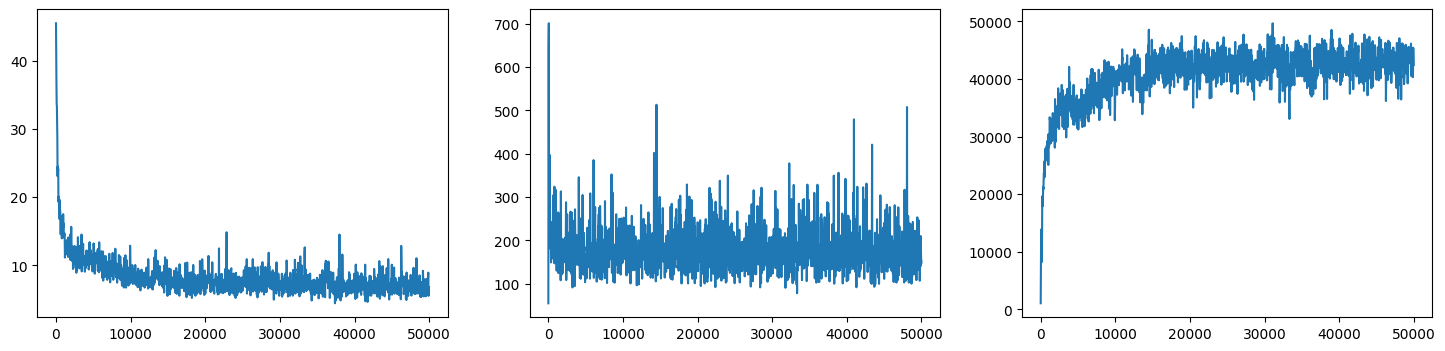

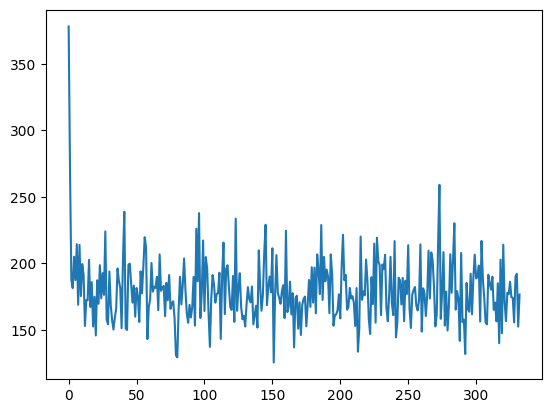

In [7]:
# Read various quantities from the file

nn1=16
lrr1=prog_list[nn1]['lr']
print(f'Position: {nn1} of {len(prog_list)}, LR = { lrr1 }, 2/LR: {2/lrr1}')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].plot(prog_list[nn1]['times'],prog_list[nn1]['loss'])
axs[1].plot(prog_list[nn1]['times'],prog_list[nn1]['sharpness'])
axs[2].plot(prog_list[nn1]['times'],prog_list[nn1]['trace'])
plt.show()
delta=5
avg=[sum(prog_list[nn1]['sharpness'][i*delta:(i+1)*delta])/delta for i in range(int(prog_list[nn1]['sharpness'].shape[0]/delta))]
plt.plot(avg[:])

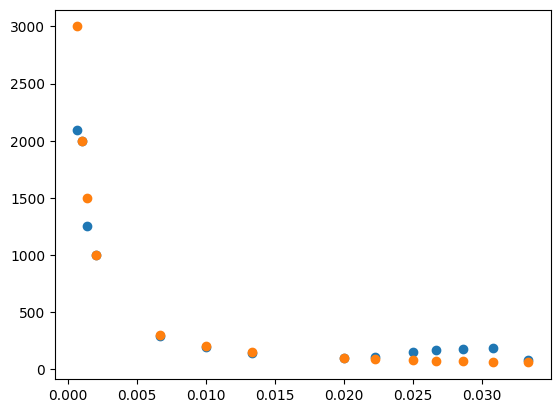

In [ ]:
# Write down list of pairs (learning rate, S), where S is the asymptotic sharpness (i.e. top Hessian eigenvalue)

results = torch.tensor([[2/90,110],[2/75,168],[2/65,185],[2/80,150],[2/60,80],[2/70,180],[2/100,100],[2/300,295],[2/3000,2090],[2/2000,2000],[2/1500,1250],
         [2/1000,1000],[2/150,147],[2/200,195]]).T

# Compare with theoretical value of S expected from Edge of Stability: S = 2 / (learning rate)
EoS = torch.tensor([[results[0][k],2/results[0][k]] for k in range(len(results[0]))]).T

# Plot the empirical and theoretical values:

plt.plot(results[0],results[1],'o')
plt.plot(EoS[0],EoS[1],'o')

In [ ]:
#Initialize file
progress_list=[]
with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'wb') as handle:
    pickle.dump(progress_list, handle, protocol=pickle.HIGHEST_PROTOCOL)